# REGRESSION From Scratch With SALES PREDICTION

#### In this Notebook we will Learn:-
* Basic EDA.
* Feature Engineering
* Dealing with missing values.
* Aplly Scaling on Feature matrix.
* Dealing with Categorical Dataset.
* Dimensionality Reduction (PCA) .
* K-Cross validation to check accuracy.
* Multi-linear Regression
* Random Forest Regressor
* Polynomial Regression
* Prediction on new Values.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, download_plotlyjs, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import warnings
warnings.filterwarnings('ignore')


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print("The files in the dataset are:-")
print(os.listdir("../input"))
print()

# Any results you write to the current directory are saved as output.


The files in the dataset are:-
['Test.csv', 'Train.csv']



In [60]:
#Importing the datasets
df_train = pd.read_csv('../input/Train.csv')
df_test = pd.read_csv('../input/Test.csv')

In [61]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [62]:
df_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [63]:
df_train.shape

(8523, 12)

In [64]:
df_test.shape

(5681, 11)

# BASIC ANALYSIS AND FEATURES ENGINEERING

#### 1). Removing Unwanted Columns/Features.

In [65]:
try:
    df_train.drop(labels=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'], axis=1, inplace=True)
    df_test.drop(labels=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'], axis=1, inplace=True)
except Exception as e:
    pass

In [66]:
df_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


#### 2). Getting Information about Null values,

In [67]:
temp_df = df_train.isnull().sum().reset_index()
temp_df['Percentage'] = (temp_df[0]/len(df_train))*100
temp_df.columns = ['Column Name', 'Number of null values', 'Null values in percentage']
print(f"The length of dataset is \t {len(df_train)}")
temp_df

The length of dataset is 	 8523


,Column Name,Number of null values,Null values in percentage
0,Item_Weight,1463,17.165317
1,Item_Fat_Content,0,0.000000
2,Item_Visibility,0,0.000000
3,Item_Type,0,0.000000
4,Item_MRP,0,0.000000
5,Outlet_Size,2410,28.276428
6,Outlet_Location_Type,0,0.000000
7,Outlet_Type,0,0.000000
8,Item_Outlet_Sales,0,0.000000


* So it is clear that we do not have to remove null values, as they 28% and 17% in the Outlet_Size and Item_Weight Columns respectively.
* Null values are in less quantity.
* We will replace them later with thier mean or mode values.

#### 3). Making Correction in 'Item_Fat_Content' column.

In [68]:
def convert(x):
    if x in ['low fat', 'LF']: 
        return 'Low Fat'
    elif x=='reg':
        return 'Regular'
    else:
        return x

df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].apply(convert)
df_test['Item_Fat_Content'] = df_train['Item_Fat_Content'].apply(convert)

print(f"Now Unique values in this column in Train Set are\t  {df_train['Item_Fat_Content'].unique()} ")
print(f"Now Unique values in this column in Test Set are\t  {df_test['Item_Fat_Content'].unique()} ")

Now Unique values in this column in Train Set are	  ['Low Fat' 'Regular'] 
Now Unique values in this column in Test Set are	  ['Low Fat' 'Regular'] 


#### 4). Dealing with the Missing Values in Categorical type column i.e. 'Outlet_Size'

In [69]:
# Counting the values
count = df_train['Outlet_Size'].value_counts().reset_index()
count.iplot(kind='bar', color='pink', x='index', y='Outlet_Size', title='High VS Medium VS Small', xTitle='Size', yTitle='Frequency')


In [70]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

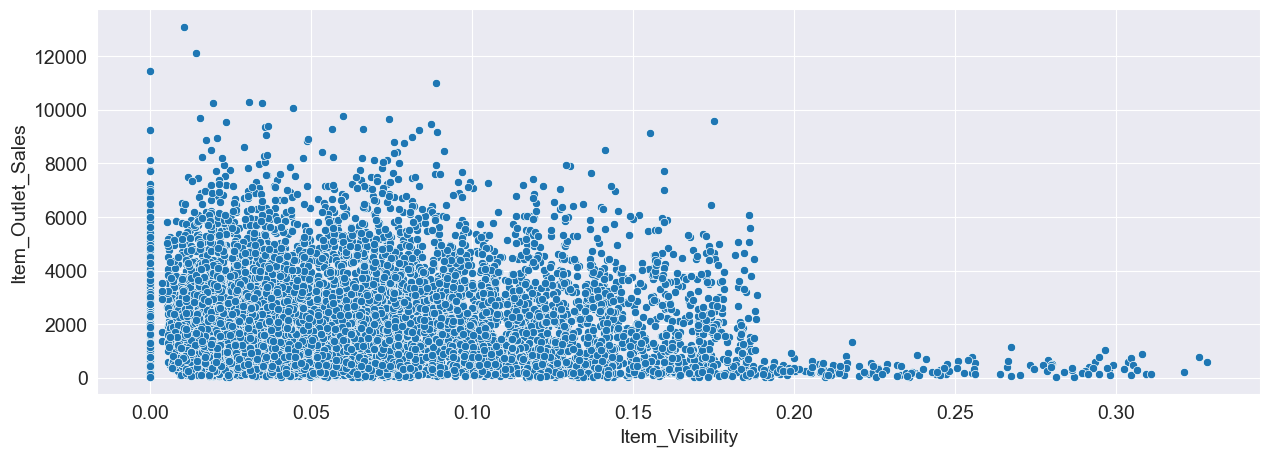

In [71]:
plt.figure(figsize=(15,5))
sns.scatterplot(x = df_train['Item_Visibility'], y = df_train['Item_Outlet_Sales'])
plt.show()

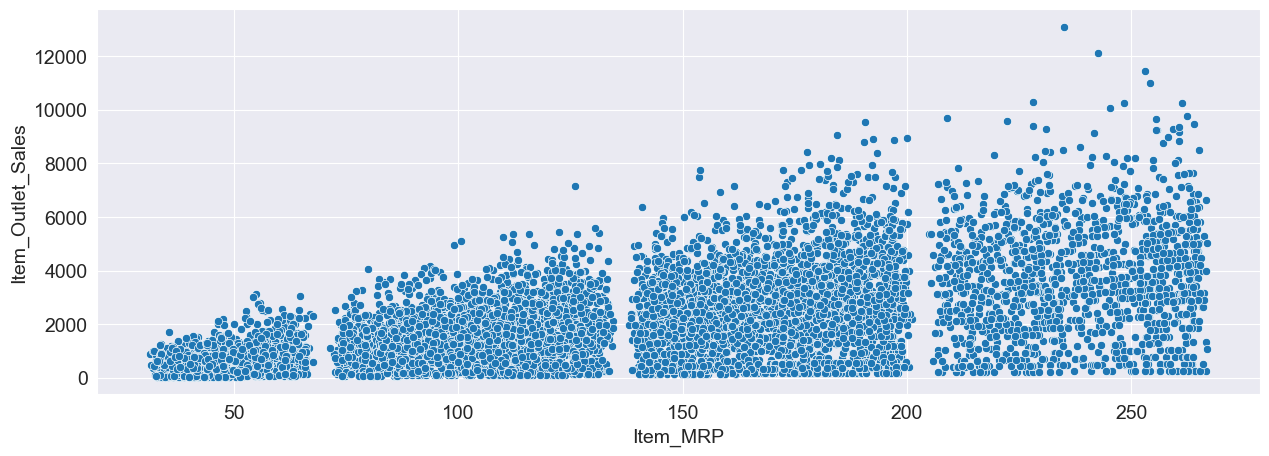

In [72]:
# question plot a relation between item price and item outlet sales
# answers item having price between 170-250 having highest sales


plt.figure(figsize=(15,5))
sns.scatterplot(x = df_train['Item_MRP'], y = df_train['Item_Outlet_Sales'])
plt.show()

* We will remove the missing values from 'Medium' in both Training set and Test set.

In [73]:
df_train['Outlet_Size'].fillna(value='Medium', inplace= True)
df_test['Outlet_Size'].fillna(value='Medium', inplace= True)

### ===============================================================================

# PREDICTION WITH REGRESSION MODELS.

In [74]:
# Let us Import the Important Libraries  to train our Model for Machine Learning 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder # To deal with Categorical Data in Target Vector.
from sklearn.model_selection import train_test_split  # To Split the dataset into training data and testing data.
from sklearn.model_selection import cross_val_score   # To check the accuracy of the model.
from sklearn.impute import SimpleImputer  # To deal with the missing values
from sklearn.preprocessing import StandardScaler   # To apply scaling on the dataset.
from sklearn.compose import ColumnTransformer

In [75]:
# Let us create feature matrix and Target Vector.
x_train = df_train.iloc[:, :-1].values    # Features Matrix
y_train = df_train.iloc[:,-1].values   # Target Vector
x_test = df_test.values    # Features Matrix

In [76]:
df_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,Medium,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


### 1). Dealing with Missing data.

In [77]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
x_train[:,[0]] = imputer.fit_transform(x_train[:,[0]])
x_test[:,[0]] = imputer.fit_transform(x_test[:,[0]])


### 2). Dealing With the Categorical Values in Features/Columns.

In [78]:
labelencoder_x = LabelEncoder()
x_train[:, 1 ] = labelencoder_x.fit_transform(x_train[:,1 ])
x_train[:, 3 ] = labelencoder_x.fit_transform(x_train[:,3 ])
x_train[:, 5 ] = labelencoder_x.fit_transform(x_train[:,5 ])
x_train[:, 6 ] = labelencoder_x.fit_transform(x_train[:,6 ])
x_train[:, 7 ] = labelencoder_x.fit_transform(x_train[:,7 ])

#this is need to done when we have more than two categorical values.

transformer = ColumnTransformer(
    transformers=[
        ("OneHot",              # Just a name
         OneHotEncoder(),       # The transformer class
         [3,5,6,7]              # The column(s) to be applied on.
         )
    ],
    remainder='passthrough' # donot apply anything to the remaining columns
)
x_train = transformer.fit_transform(x_train.tolist()).toarray()



# Let's apply same concept on test set.
x_test[:, 1 ] = labelencoder_x.fit_transform(x_test[:,1 ])
x_test[:, 3 ] = labelencoder_x.fit_transform(x_test[:,3 ])
x_test[:, 5 ] = labelencoder_x.fit_transform(x_test[:,5 ])
x_test[:, 6 ] = labelencoder_x.fit_transform(x_test[:,6 ])
x_test[:, 7 ] = labelencoder_x.fit_transform(x_test[:,7 ])


#this is need to done when we have more than two categorical values.

transformer = ColumnTransformer(
    transformers=[
        ("OneHot",              # Just a name
         OneHotEncoder(),       # The transformer class
         [3,5,6,7]              # The column(s) to be applied on.
         )
    ],
    remainder='passthrough' # donot apply anything to the remaining columns
)
x_test = transformer.fit_transform(x_test.tolist()).toarray()

### 3). Now time to Apply Feature Scaling on Feature matrix .

In [79]:
sc_X=StandardScaler() # (x - mean) /standard deviation
x_train=sc_X.fit_transform(x_train)
x_test = sc_X.fit_transform(x_test)

### 4). DIMENSIONALITY REDUCTION
* We are doing this to reduce the number of dimensions/features in the dataset.
* The features which have less effect on the prediction , we will remove those features.
* It also boosts the process.
* It saves time.
* Here we will use Principal Component Analysis (PCA)

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([1.07436620e-01, 7.06641260e-02, 5.70498830e-02, 4.09526251e-02,
       3.95467905e-02, 3.88413840e-02, 3.80440510e-02, 3.71894944e-02,
       3.66121233e-02, 3.65974914e-02, 3.61940767e-02, 3.60438629e-02,
       3.53858680e-02, 3.51548734e-02, 3.47992044e-02, 3.44677719e-02,
       3.44402278e-02, 3.41700689e-02, 3.39346717e-02, 3.33812480e-02,
       3.24927908e-02, 3.11279656e-02, 2.98113386e-02, 2.94882832e-02,
       2.37652498e-02, 2.40790966e-03, 3.53592719e-30, 2.55376465e-31,
       1.90804590e-31, 8.32245677e-32])

* Here we will take n_component = 24.

In [81]:
pca = PCA(n_components=25)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

### 5). Apply Multi-Linear Regression Model, Polynomial Regression and Random Forest Model and compare thier accuracy and pick the best one.

#### Multi-Linear Regression

In [82]:
# Multi-linear regression Model.
regressor_multi = LinearRegression()
regressor_multi.fit(x_train,y_train)

# Let us check the accuray
accuracy = cross_val_score(estimator=regressor_multi, X=x_train, y=y_train,cv=10)
print("****Multi-Linear Regression****")
print(f"The accuracy of the Multi-linear Regressor Model is \t {accuracy.mean()*100}")
print(f"The deviation in the accuracy is \t {accuracy.std()*100}")


****Multi-Linear Regression****
The accuracy of the Multi-linear Regressor Model is 	 55.757640458564914
The deviation in the accuracy is 	 2.120576291236601


#### Random Forest Model

In [83]:
# Random Forest Model.
regressor_random = RandomForestRegressor(n_estimators=100,)
regressor_random.fit(x_train,y_train)

# Let us check the accuray
accuracy = cross_val_score(estimator=regressor_random, X=x_train, y=y_train,cv=10)
print("****Random Forest Regression****")
print(f"The accuracy of the Random Forest Model is \t {accuracy.mean()*100}")
print(f"The deviation in the accuracy is \t {accuracy.std()*100}")

print("Here accuray is 53% with deviation of 3%.")

****Random Forest Regression****
The accuracy of the Random Forest Model is 	 53.62524627111871
The deviation in the accuracy is 	 3.13208515705025
Here accuray is 53% with deviation of 3%.


#### Polynomial regression

In [84]:

# Fitting polynomial regression to dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg=PolynomialFeatures(degree=4) #These 3 steps are to convert X matrix into X polynomial
x_poly=poly_reg.fit_transform(x_train) #matrix. 
regressor_poly=LinearRegression()
regressor_poly.fit(x_poly,y_train)

# Let us check the accuray
accuracy = cross_val_score(estimator=regressor_poly, X=x_train, y=y_train,cv=10)
print("****Polynomial Regression****")
print(f"The accuracy of the Polynomial Regression Model is \t {accuracy.mean()*100}")
print(f"The deviation in the accuracy is \t {accuracy.std()*100}")

print("Here accuracy is 55% with deviation of 2%")

****Polynomial Regression****
The accuracy of the Polynomial Regression Model is 	 55.757640458564914
The deviation in the accuracy is 	 2.120576291236601
Here accuracy is 55% with deviation of 2%


#### observation:-
* As the accuracy of Multi-linear regression Model is the best one.
* Multi-linear Regression Model takes less time as compare to Random forest and Polynomial regression Models.
* We will choose Multi-linear regression Model.
* Here we are getting the accuracy of 55% and deviation of 2%, means in future if we make prediction on new values then we will get the accuracy in range 53% to 57%.
* We are getting low accuracy due to less quantity of data.

### Let us make Prediction on test set

In [85]:
y_pred = regressor_multi.predict(x_test)
y_pred[:5]

array([2687.0890459 , 2580.884406  ,  650.91060302, 1291.83732431,
       3967.35672418])

### ============================================================================
### ============================================================================
### ============================================================================
### ============================================================================